# Notebook to make celltyping plots to send to Joe

Assumes umap, leiden clustering, high expr. genes already calculated from `run_celltyping.py`

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tqdm
import math
import os
from pathlib import Path

In [2]:
sc.settings.set_figure_params(dpi = 120, facecolor='white')

In [3]:
# Output directory for figures/tables
dir_out = '/common/lamt2/HPV/figs/primary_iteration_1/secondary_iteration_2/stromal'

# Celltype (for naming)
celltype = 'Stromal'

# anndata file name
f_adata = 'primary_v1_Stromal_v2_latent_17_layers_4'

In [4]:
# Make output directories (one for each resolution of leiden clustering)
if not os.path.isdir(dir_out):
    Path(dir_out).mkdir(parents = True, exist_ok = True)
    for res in ['0p5', '0p7', '1p0']:
        os.mkdir(f'{dir_out}/resolution_{res}')

In [5]:
# Read in the adata
adata = sc.read_h5ad(f'/common/lamt2/HPV/data/xenium/adata/adata_leiden_{f_adata}.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 1020701 × 5001
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'slide', 'core', 'batch', 'core_idx', 'core_old', 'n_genes_by_counts', 'n_counts', 'n_genes', 'sketched', 'leiden', 'leiden_0p7', 'leiden_1p0', 'leiden_0p5', 'primary_celltype', 'annot1', 'foldmask'
    uns: 'leiden_0p5', 'leiden_0p7', 'leiden_1p0', 'neighbors', 'rank_genes_groups_0p5', 'rank_genes_groups_0p7', 'rank_genes_groups_1p0', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

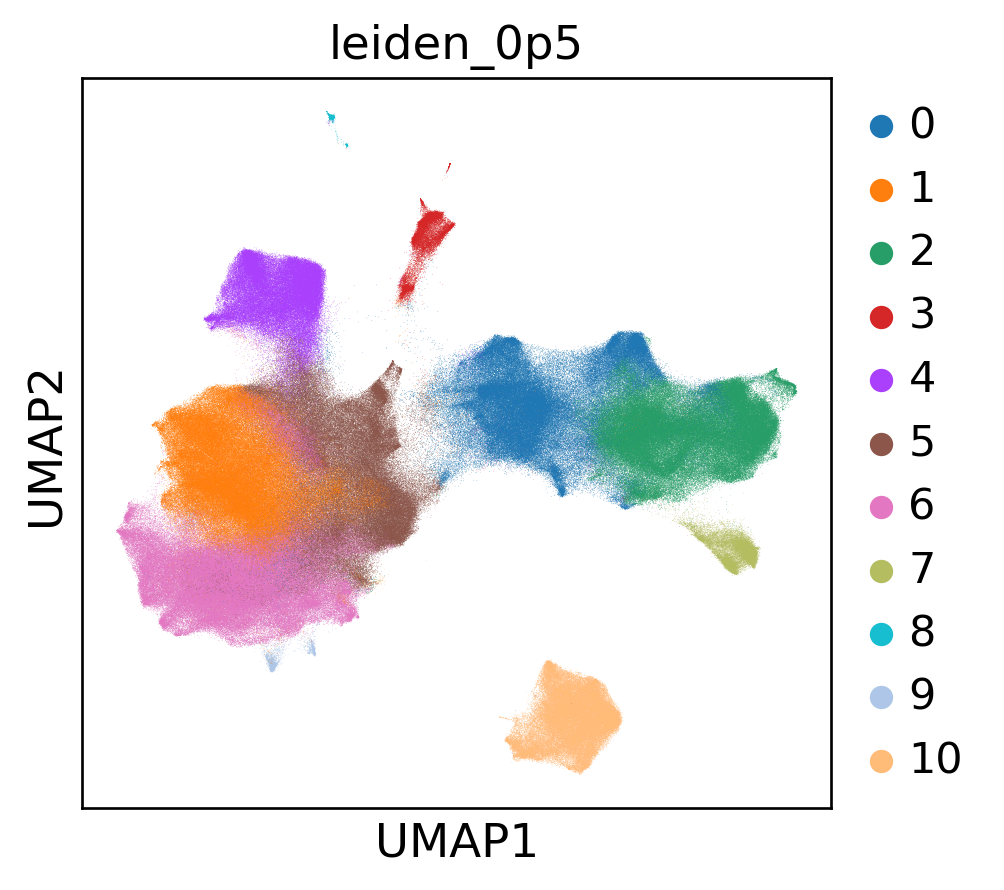

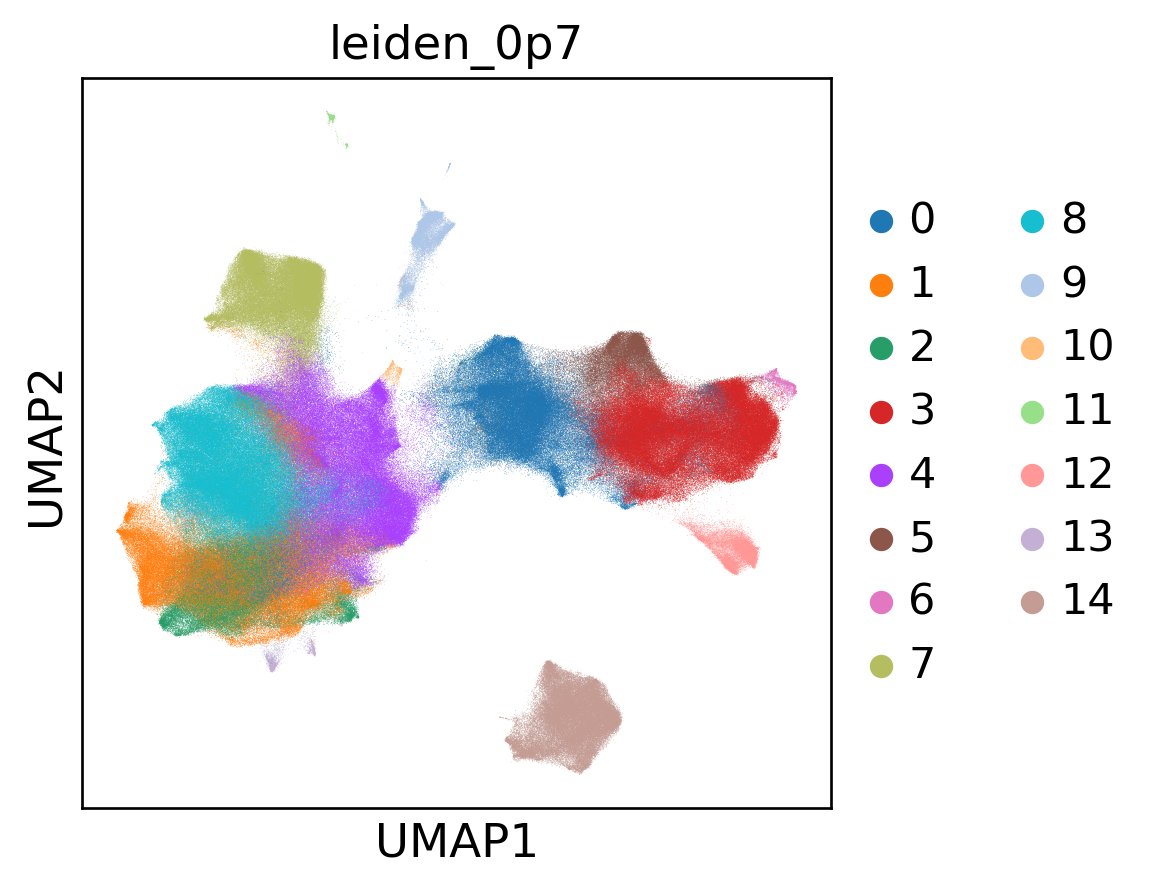

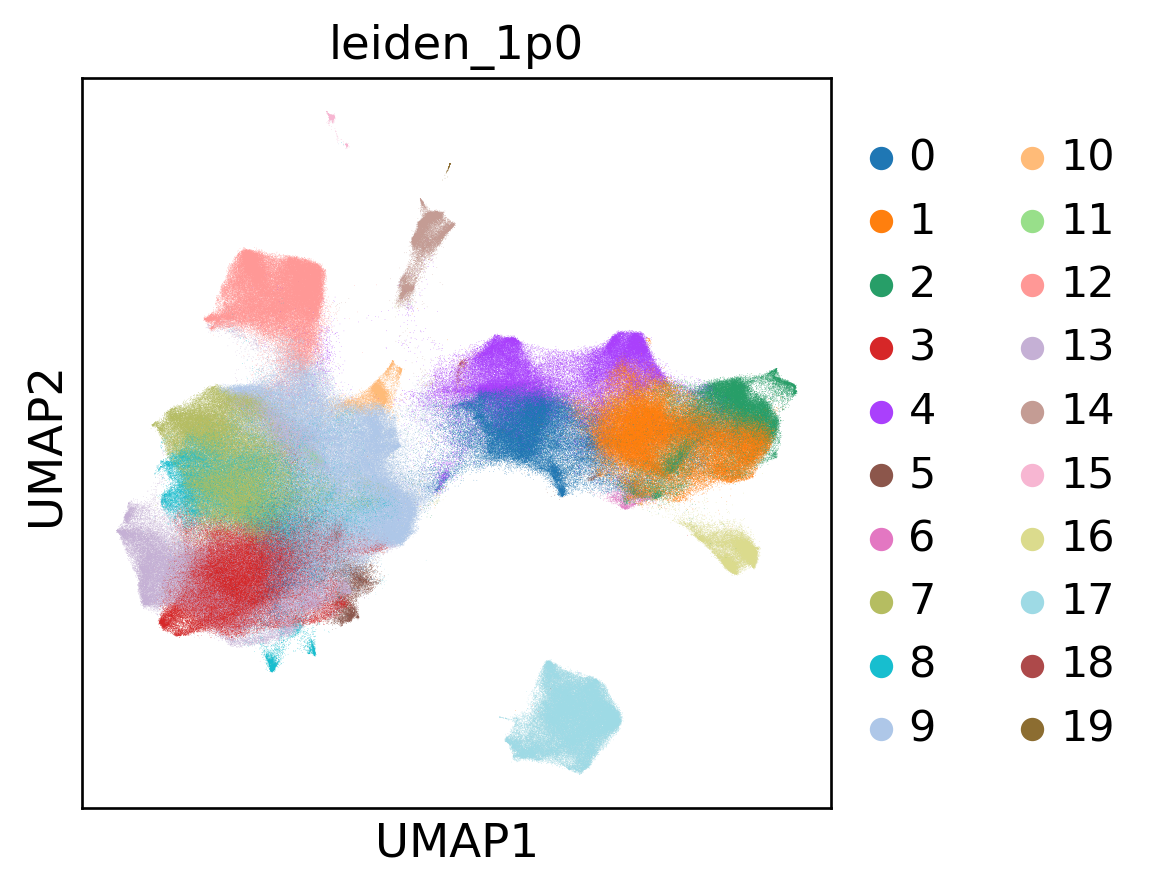

In [7]:
# Plot the umap of the leiden clusters
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace('.', 'p')
    fig = sc.pl.umap(adata, color = [f'leiden_{res}'], show = False)
    plt.savefig(f'{dir_out}/resolution_{res}/umap_{celltype}_leiden_{res}.png', bbox_inches='tight')
    plt.show()

In [8]:
# Get the number of cells, average number of genes with count > 0, and average number of total counts for each cluster at each resolution
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace('.', 'p')
    n_genes_by_counts = adata.obs.groupby(f'leiden_{res}', observed = False)['n_genes_by_counts'].mean()
    total_counts = adata.obs.groupby(f'leiden_{res}', observed = False)['total_counts'].mean()
    ncells = adata.obs.groupby(f'leiden_{res}', observed = False).size()
    ncells.name = 'n_cells'
    df = pd.concat([n_genes_by_counts, total_counts, ncells], axis = 1)
    df.to_csv(f'{dir_out}/resolution_{res}/counts_{celltype}_leiden_{res}.csv')

In [9]:
# Dataframe of top diffexp genes by wilcoxon score
ntop = 10
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace(".", 'p')
    heg = pd.DataFrame()
    for c in adata.obs[f'leiden_{res}'].unique():
        df = sc.get.rank_genes_groups_df(adata, group = c, key = f'rank_genes_groups_{res}')
        df.sort_values('scores', ascending = False)
        df = df.iloc[:ntop]
        
        gene_counts = np.array(np.sum(adata[adata.obs[f'leiden_{res}'] == c].layers['counts'], axis = 0)).flatten() / len(adata[adata.obs[f'leiden_{res}'] == c])
        gene_counts_df = pd.DataFrame({'avg_counts': gene_counts}, index = adata.var_names)
        gene_counts_df = gene_counts_df[gene_counts_df.index.isin(df.names)]
        df['avg_counts'] = df['names'].map(gene_counts_df['avg_counts'])
        
        df['cluster'] = c
        heg = pd.concat([heg, df], axis = 0)
    heg.to_csv(f'{dir_out}/resolution_{res}/diffex_genes_{celltype}_leiden_{res}.csv')

In [10]:
# Dataframe of top expressed genes (by total counts)
ntop = 20
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace(".", 'p')
    heg = pd.DataFrame()
    for c in adata.obs[f'leiden_{res}'].unique():
        gene_counts = np.array(np.sum(adata[adata.obs[f'leiden_{res}'] == c].layers['counts'], axis = 0)).flatten() / len(adata[adata.obs[f'leiden_{res}'] == c])
        gene_counts_df = pd.DataFrame({'avg_counts': gene_counts}, index = adata.var_names)
        genes = gene_counts_df.sort_values('avg_counts', ascending = False).head(ntop).index.values
                
        df = sc.get.rank_genes_groups_df(adata, group = c, key = f'rank_genes_groups_{res}')
        df = df[df['names'].isin(genes)].sort_values('scores', ascending = False)
        df.sort_values('scores', ascending = False)
        df = df.iloc[:ntop]
        df.reset_index(drop = True)
        df['avg_counts'] = df['names'].map(gene_counts_df['avg_counts'])
        df['cluster'] = c
        heg = pd.concat([heg, df], axis = 0)
    heg.to_csv(f'{dir_out}/resolution_{res}/highex_genes_{celltype}_leiden_{res}.csv')

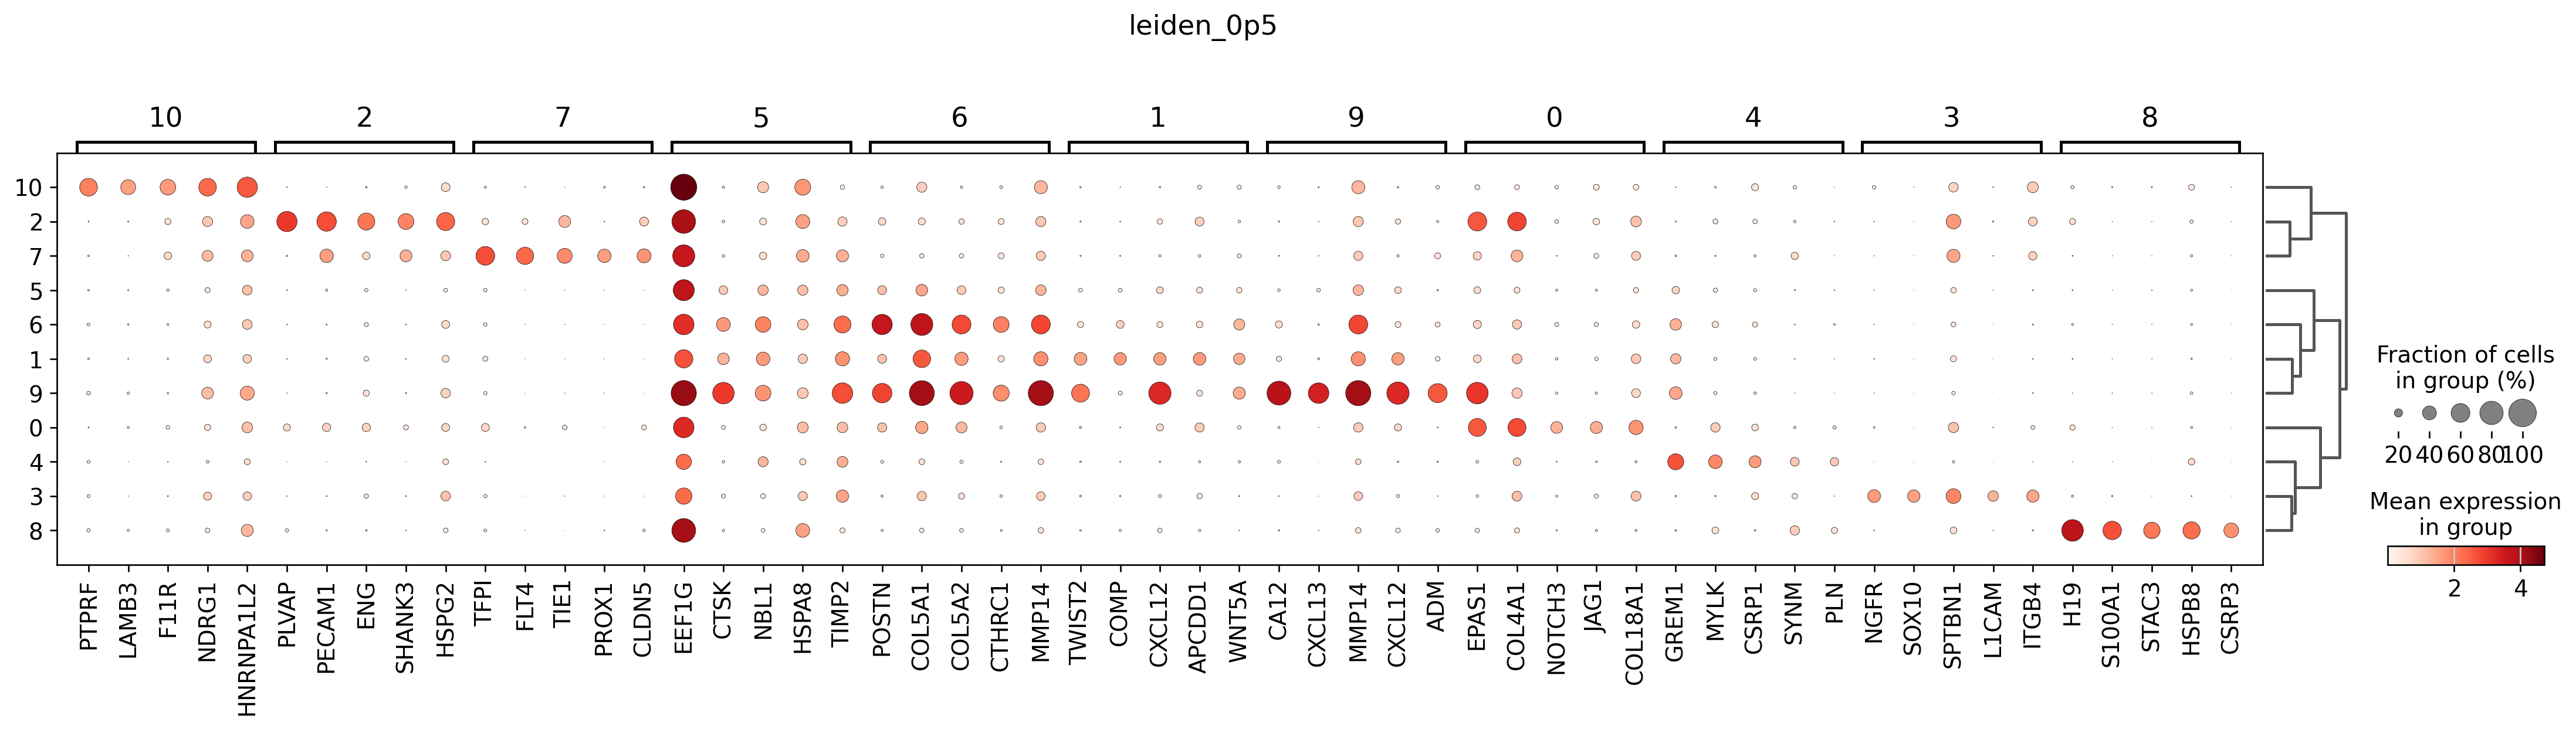

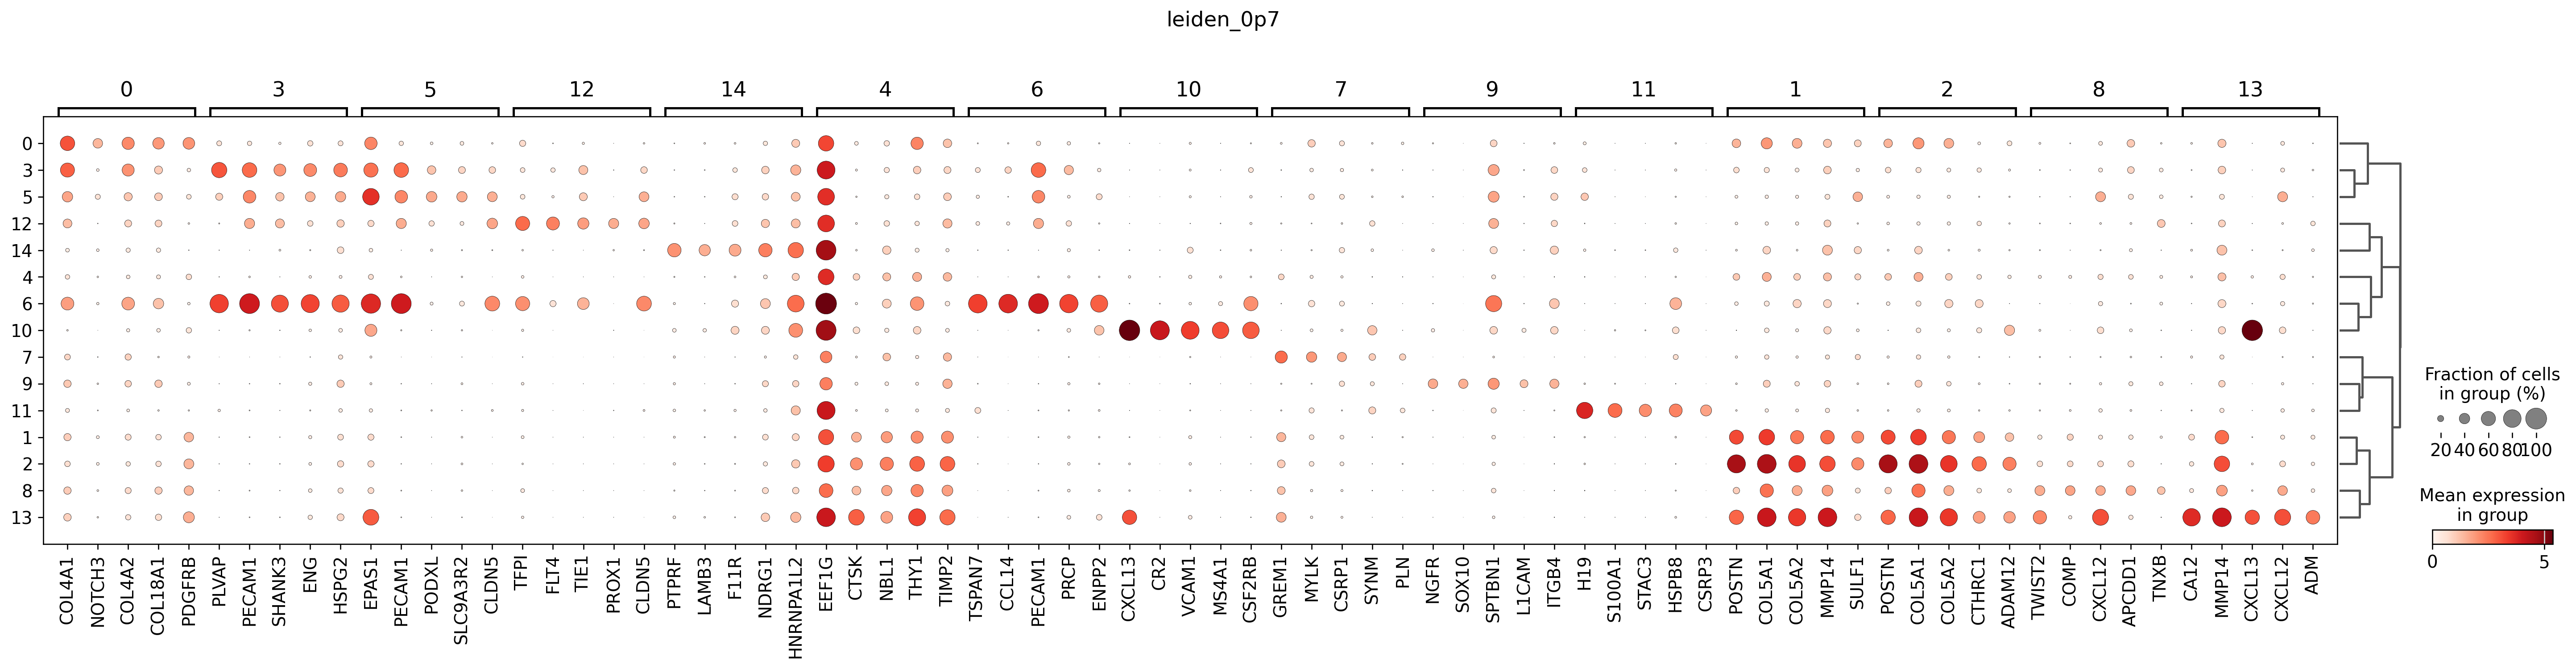

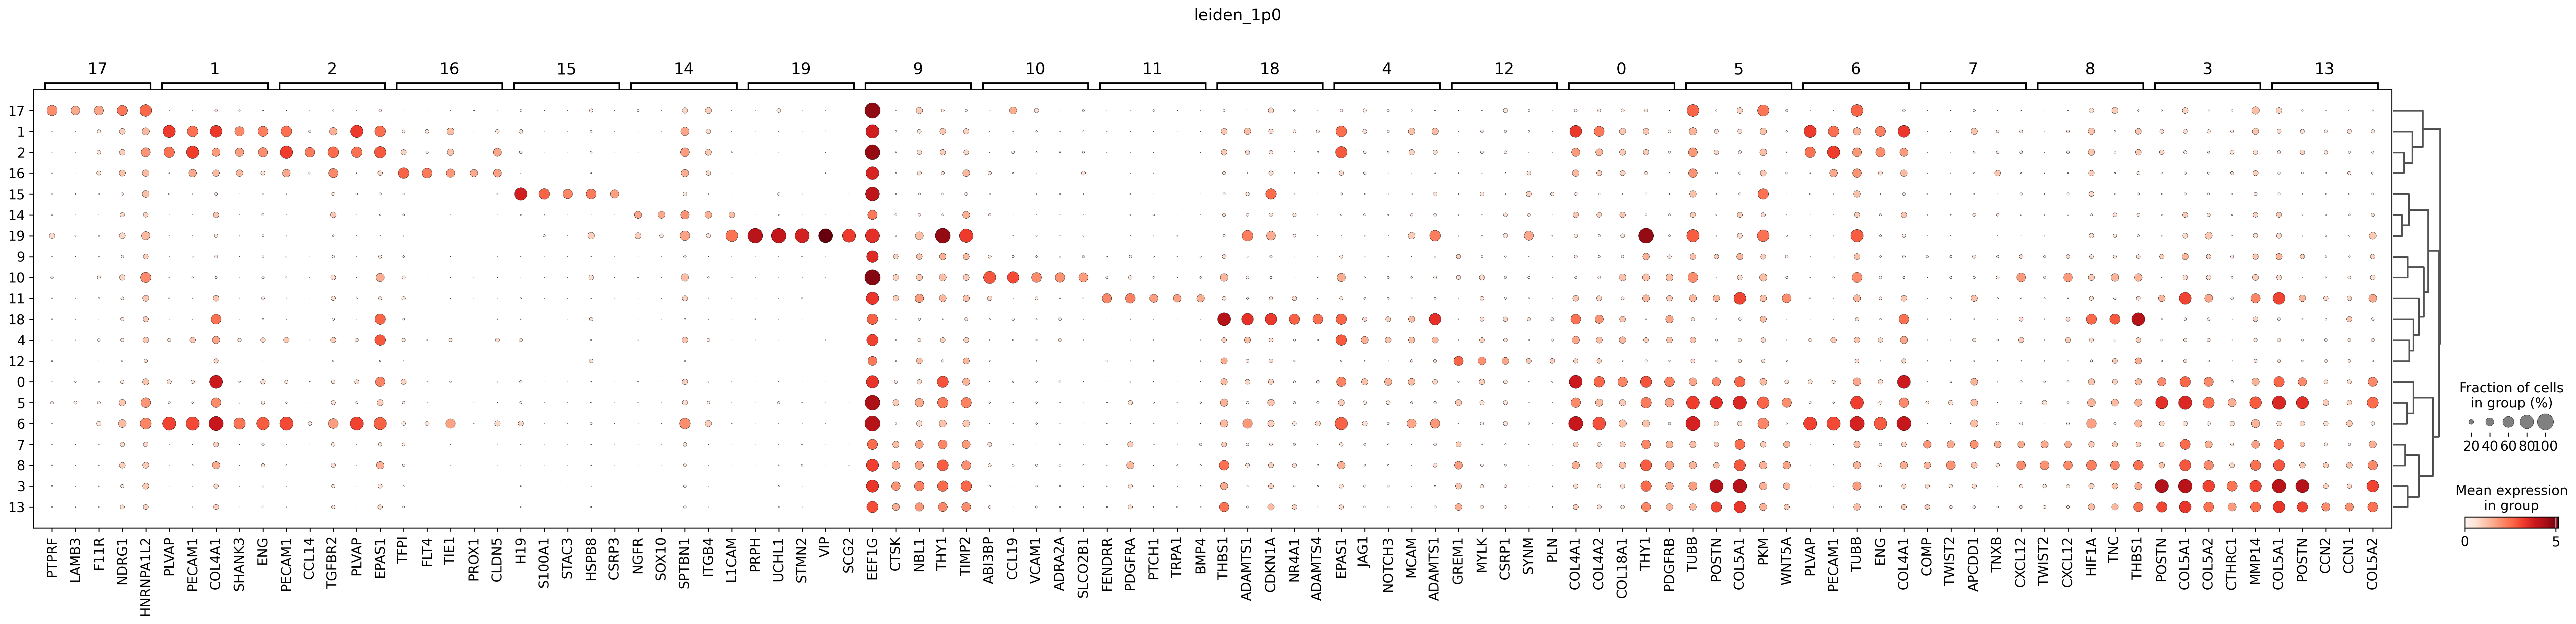

In [11]:
# Dot plot of top 5 expressed genes (with >20% of cells in cluster expressing) by wilcoxen score per leiden cluster
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace(".", 'p')
    marker_genes = {}
    markers = []
    top = 5
    for c in adata.obs[f'leiden_{res}'].unique():
        df = sc.get.rank_genes_groups_df(adata, group = c, key = f'rank_genes_groups_{res}')
        df = df.loc[df['pct_nz_group'] > 0.2]
        df = df.sort_values('scores', ascending = False)
        genes = df.names.values
        marker_genes[c] = genes[:top]
        for g in genes[:top]:
            if (g not in markers):
                markers.append(g)
    sorted_genes = {i: marker_genes[i] for i in list(sorted(marker_genes.keys()))}
    sc.tl.dendrogram(adata, use_rep="X_scVI", groupby=f"leiden_{res}")
    sc.pl.dotplot(adata, var_names = sorted_genes, groupby=f"leiden_{res}", title = f"leiden_{res}", dendrogram=True, show = False)
    plt.savefig(f'{dir_out}/resolution_{res}/dotplot_{celltype}_leiden_{res}.png', bbox_inches = 'tight')
    plt.show()

### Occasionally Joe needs some extra genes in the dotplot. Here are some examples of how to get them

In [ ]:
# Keratin Genes
genes = [x for x in adata.var_names if x.startswith("KRT")]
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace('.', 'p')
    sc.tl.dendrogram(adata, use_rep = 'X_scVI', groupby = f'leiden_{res}')
    sc.pl.dotplot(adata, var_names = genes, groupby = f'leiden_{res}', dendrogram = True, title = f'leiden_{res}', show = False)
    plt.savefig(f'{dir_out}/resolution_{res}/dotplot_{celltype}_leiden_{res}_keratin_genes.png', bbox_inches = 'tight')
    plt.show()

In [ ]:
# Immune extra genes
genes = ['CD19', 'CD79A', 'CD3E', 'CD68', 'CD14', 'MS4A1', 'CD4', 'IRF8']
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace('.', 'p')
    sc.tl.dendrogram(adata, use_rep = 'X_scVI', groupby = f'leiden_{res}')
    sc.pl.dotplot(adata, var_names = genes, groupby = f'leiden_{res}', dendrogram = True, title = f'leiden_{res}', show = False)
    plt.savefig(f'{dir_out}/resolution_{res}/dotplot_{celltype}_leiden_{res}_Immune_genes.png', bbox_inches = 'tight')
    plt.show()

In [ ]:
# Myeloid extra genes
genes = ['CD4', 'CD14', 'CD163', 'CD68', 'CD3E', 'FUT4', 'MPO', 'ITGAX']
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace(".", 'p')
    sc.tl.dendrogram(adata, use_rep="X_scVI", groupby=f"leiden_{res}")
    sc.pl.dotplot(adata, var_names = genes, groupby=f"leiden_{res}", dendrogram=True, show = False, title = f'leiden_{res}')
    plt.savefig(f'{dir_out}/resolution_{res}/dotplot_{celltype}_leiden_{res}_Myeloid_genes.png', bbox_inches = 'tight')
    plt.show()

In [ ]:
# B_Plasma extra genes
genes = ['CD68', 'CD14', 'CD79A', 'FCGR2A', 'FUT4', 'MPO']
for resolution in [0.5, 0.7, 1.0]:
    res = str(resolution).replace(".", 'p')
    sc.tl.dendrogram(adata, use_rep="X_scVI", groupby=f"leiden_{res}")
    sc.pl.dotplot(adata, var_names = genes, groupby=f"leiden_{res}", dendrogram=True, show = False, title = f'leiden_{res}')
    plt.savefig(f'{dir_out}/resolution_{res}/dotplot_{celltype}_leiden_{res}_B_Plasma_genes.png', bbox_inches = 'tight')
    plt.show()